In [ ]:
treeTermPath <- '/fs/cbcb-lab/rob/students/noor/Uncertainity/treeTerminusScripts'
suppressPackageStartupMessages(source(file.path(treeTermPath, "tree_helper_function.R")))
suppressPackageStartupMessages(source(file.path(treeTermPath, "tree_term_climb.R")))
suppressPackageStartupMessages(library(beaveR))

seed <- 10
mainDir <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/brain_sim_null/post_type=gibbs_nrep=100_tf=100"
clustFile <- file.path(mainDir, "terminus", paste("seed",seed,sep="="), "no_threshold0", "cluster_nwk.txt")
quantDir <- file.path(mainDir, "out_sal", paste("seed",seed,sep="="))
samples <- as.vector(outer(c(1:6), c(1,2), function(x,y) paste(x,y,sep='_')))
quantFiles <- file.path(quantDir, samples, 'quant.sf')
coldata <- data.frame(files=quantFiles, names=samples, condition=factor(rep(1:2, each=6)))

tse <- buildTSE(treeTermFile = clustFile, coldata = coldata)
tree <- rowTree(tse)
nl <- length(tree$tip)
                           


reading tree

importing quantifications

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 


found matching transcriptome:
[ GENCODE - Homo sapiens - release 26 ]

loading existing TxDb created: 2023-03-02 17:08:07

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi

loading existing transcript ranges created: 2023-03-02 21:45:10

Missing txps 3894

Aggregation Started

Aggregation Ended



class: TreeSummarizedExperiment 
dim: 254477 12 
metadata(8): tximetaInfo quantInfo ... txpsAnn infRepsScaled
assays(105): counts abundance ... mean variance
rownames(254477): ENST00000416931.1 ENST00000457540.1 ... Node254476
  Node254477
rowData names(1): meanInfRV
colnames(12): 1_1 2_1 ... 5_2 6_2
colData names(2): names condition
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):
rowLinks: a LinkDataFrame (254477 rows)
rowTree: 1 phylo tree(s) (138309 leaves)
colLinks: NULL
colTree: NULL

In [ ]:
gse <- summarizeToGene(tse)
txpGene <- SummarizedExperiment(assays= list(counts = rbind(assays(tse)[["counts"]][1:nl,], assays(gse)[["counts"]]),
                                           length = rbind(assays(tse)[["length"]][1:nl,], assays(gse)[["length"]]),
                                           abundance = rbind(assays(tse)[["abundance"]][1:nl,], assays(gse)[["abundance"]])), 
                                   colData = colData(tse),
                                   )

dim(txpGene)
for(i in seq(100)) {
    inf <- paste("infRep", i, sep = "")
    assays(txpGene)[[inf]] <- rbind(assays(tse)[[inf]][1:nl,], assays(gse)[[inf]])
}
metadata(txpGene)[["txpsAnn"]] <- metadata(tse)[["txpsAnn"]]
metadata(txpGene)[["infRepsScaled"]] <- FALSE

In [3]:
cSF <- function (tse, type = "txp", lengthCorrect = TRUE, meanDepth = NULL, 
    sfFun = NULL, minCount = 10, minN = 3, quiet = FALSE, force = FALSE) 
{
    metadata(tse)[["type"]] <- type
    l <- nrow(metadata(tse)[["txpsAnn"]])
    
    tseT <- tse
    tseT <- tse[1:l, ]
    if (type == "gene") {
        gse <- summarizeToGene(tseT)
    }
    infRepIdx <- grep("infRep", assayNames(tse))
    counts <- if (type == "txp") 
        assays(tseT)[["counts"]]
    else assays(gse)[["counts"]]
    infReps <- if (type == "txp") 
        assays(tseT)[infRepIdx]
    else assays(gse)[infRepIdx]
    length <- if (type == "txp") 
        assays(tseT)[["length"]]
    else assays(gse)[["length"]]
    nreps <- length(infReps)
    if (is.null(meanDepth) & is.null(sfFun)) {
        meanDepth <- exp(mean(log(colSums(counts))))
    }
    sizeMat <- matrix(nrow = nreps, ncol = ncol(tse))
    if (is.null(length)) {
        if (lengthCorrect) {
            if (!quiet) 
                message("not correcting for feature length (lengthCorrect=FALSE)")
        }
        lengthCorrect <- FALSE
    }
    for (k in seq_len(nreps)) {
        if (!quiet) 
            svMisc::progress(k, max.value = nreps, init = (k == 
                1), gui = FALSE)
        if (lengthCorrect) {
            length <- length/exp(rowMeans(log(length)))
            cts <- infReps[[k]]/length
        }
        else {
            cts <- infReps[[k]]
        }
        if (is.null(sfFun)) {
            cts <- t(t(cts)/colSums(cts)) * meanDepth
            use <- rowSums(infReps[[k]] >= minCount) >= minN
            loggeomeans <- rowMeans(log(cts[use, ]))
            sf <- apply(cts[use, ], 2, function(s) {
                exp(median((log(s) - loggeomeans)[is.finite(loggeomeans)]))
            })
        }
        else {
            sf <- sfFun(cts)
        }
        infReps[[k]] <- t(t(cts)/sf)
        sizeMat[k, ] <- sf
    }
    metadata(tse)$sf <- sizeMat
    tse
}

In [ ]:
yG <- cSF(txpGene)
dim(yG)
yG <- scaleInfReps(yG)
dim(yG)
set.seed(10)
yG <- labelKeep(yG)
out <- swish(yG, x="condition", returnNulls = TRUE)

Progress:   1 on 100Progress:   2 on 100Progress:   3 on 100Progress:   4 on 100Progress:   5 on 100Progress:   6 on 100Progress:   7 on 100Progress:   8 on 100Progress:   9 on 100Progress:  10 on 100Progress:  11 on 100Progress:  12 on 100Progress:  13 on 100Progress:  14 on 100Progress:  15 on 100Progress:  16 on 100Progress:  17 on 100Progress:  18 on 100Progress:  19 on 100Progress:  20 on 100Progress:  21 on 100Progress:  22 on 100Progress:  23 on 100Progress:  24 on 100Progress:  25 on 100Progress:  26 on 100Progress:  27 on 100Progress:  28 on 100Progress:  29 on 100Progress:  30 on 100Progress:  31 on 100Progress:  32 on 100Progress:  33 on 100Progress:  34 on 100Progress:  35 on 100Progress:  36 on 100Progress:  37 on 100Progress:  38 on 100Progress:  39 on 100Progress:  40 on 100Progress:  41 on 100Progress:  42 on 100Progress:  43 on 100Progress:  44 on 100Progress:  45 on 100Progress:  46 on 100Progress:  47 on 100Progress:  48 on 100Progress:  49 on 100Progress:  50 on 100

In [39]:
rr <- rownames(yG)[mcols(yG)[["keep"]]]
gInds <- match(rr[grep("ENSG", rr)], rr)

In [41]:
length(gInds)

[1] 19869

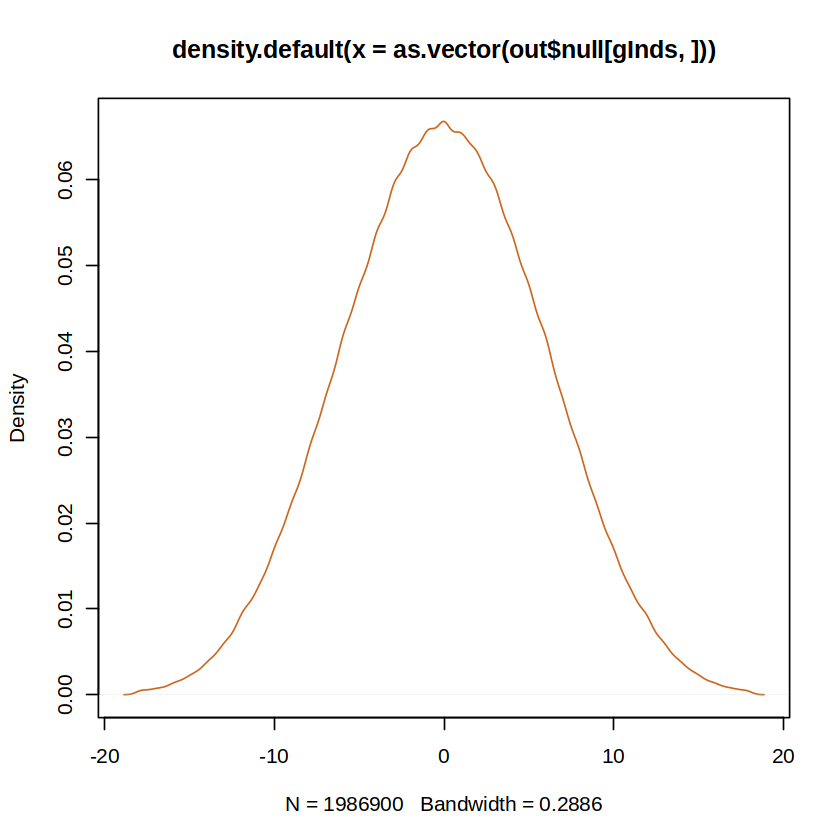

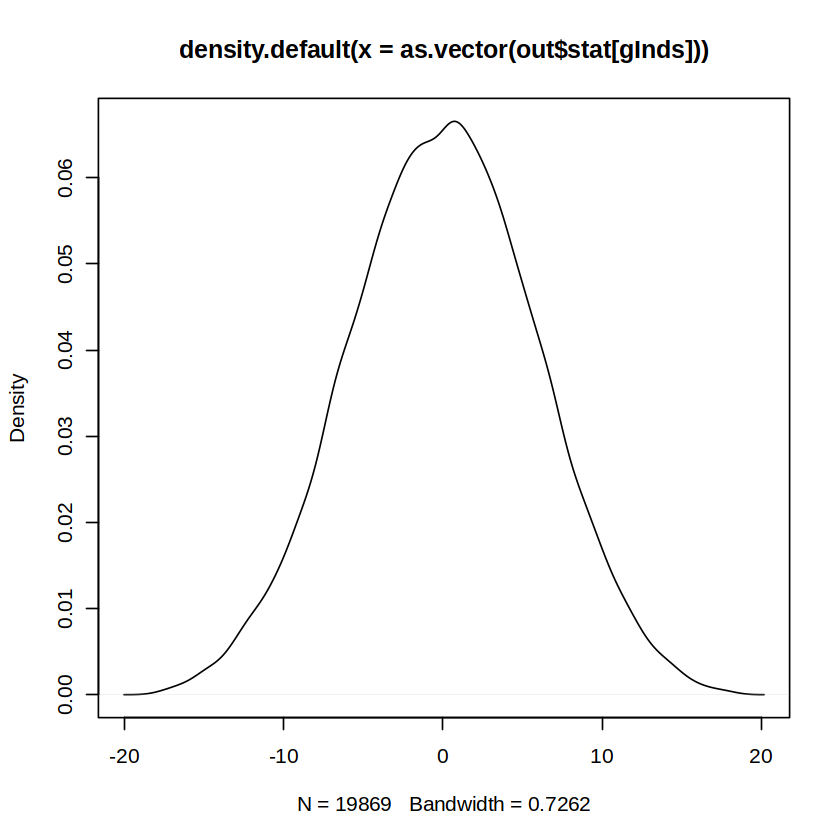

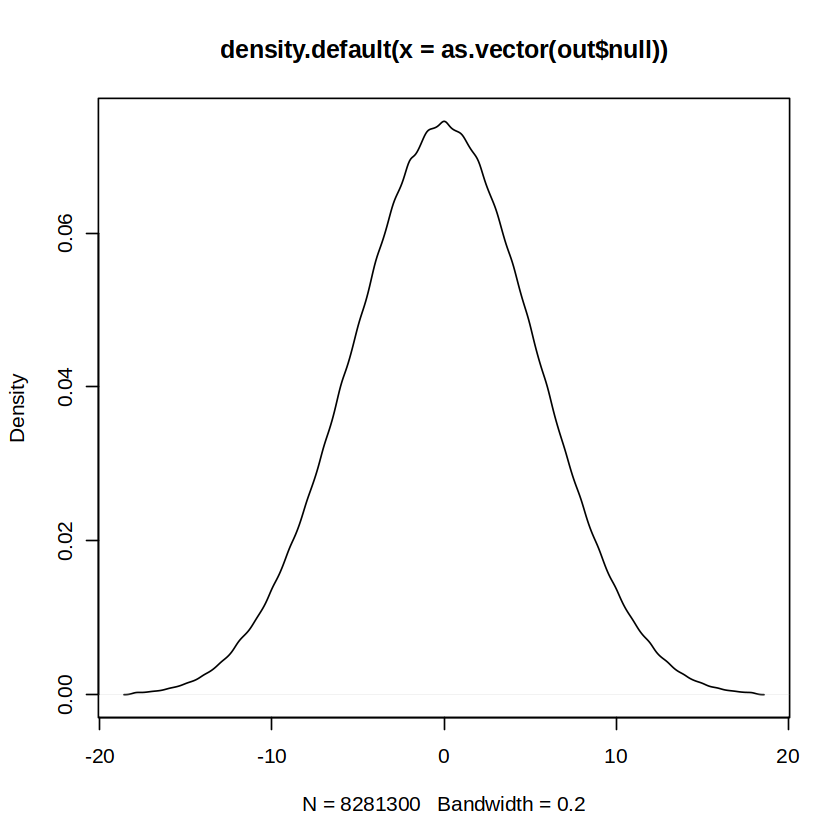

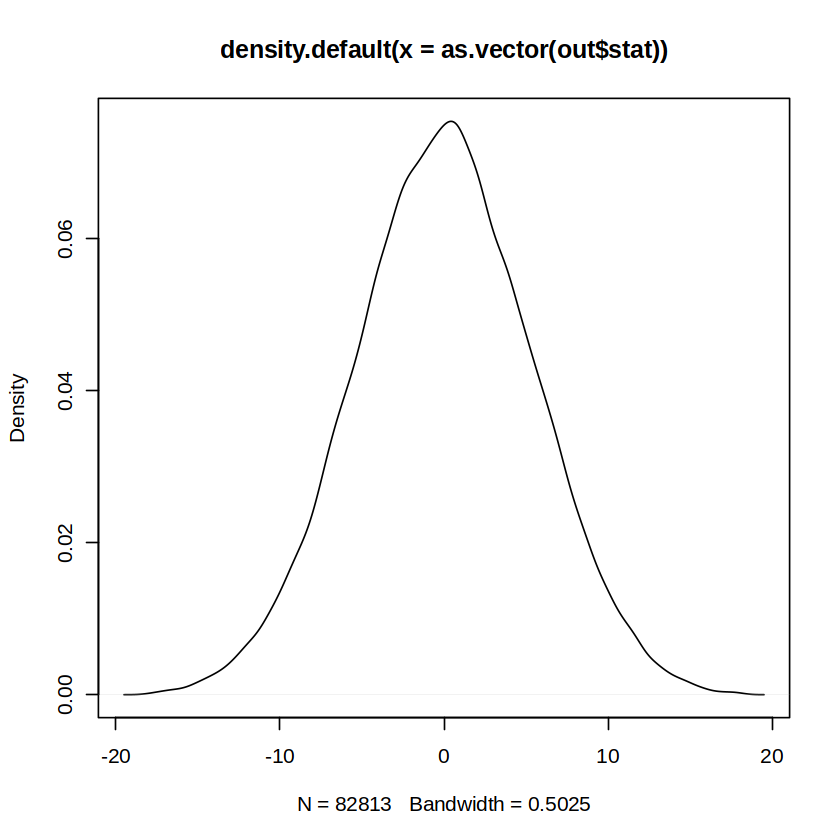

In [49]:
plot(density(as.vector(out$null[gInds,])), col = "chocolate3")
plot(density(as.vector(out$stat[gInds])))

plot(density(as.vector(out$null)))
plot(density(as.vector(out$stat)))

using counts and average transcript lengths from tximeta

using 'avgTxLength' from assays(dds), correcting for library size



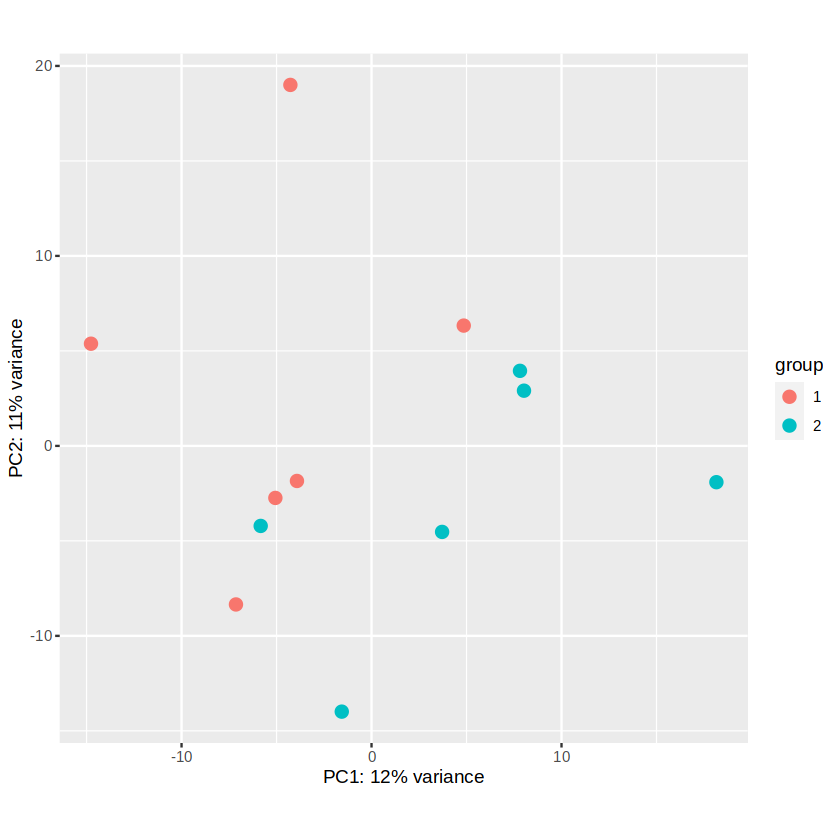

In [51]:
library(DESeq2)
suppressPackageStartupMessages(library(dplyr))
dds <- DESeqDataSet(gse, design=~condition)
dds %>% vst %>% plotPCA(ntop=1000)

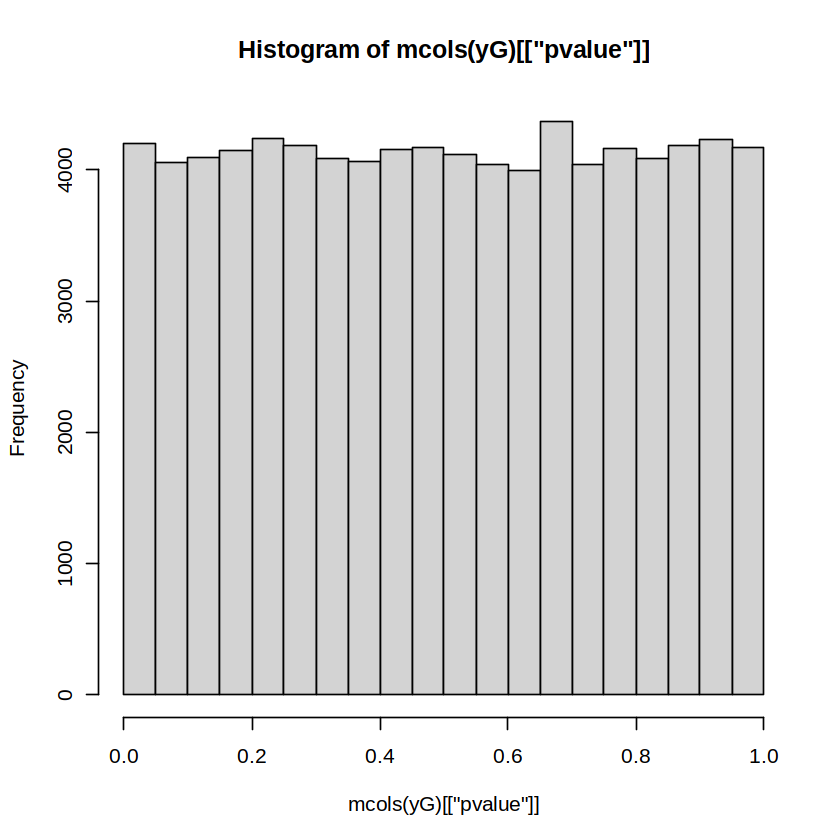

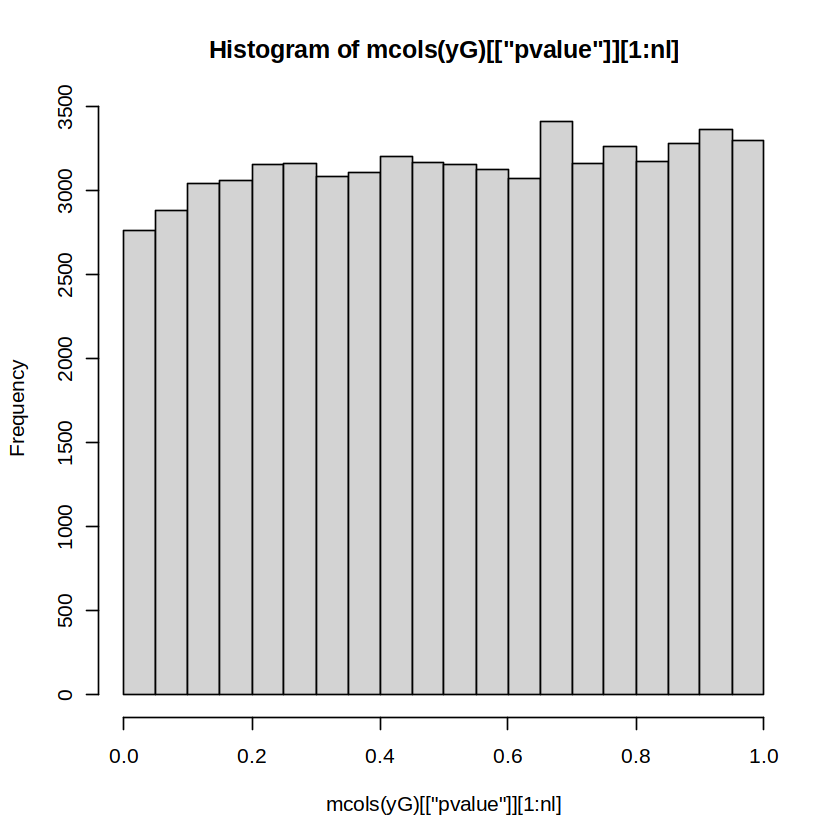

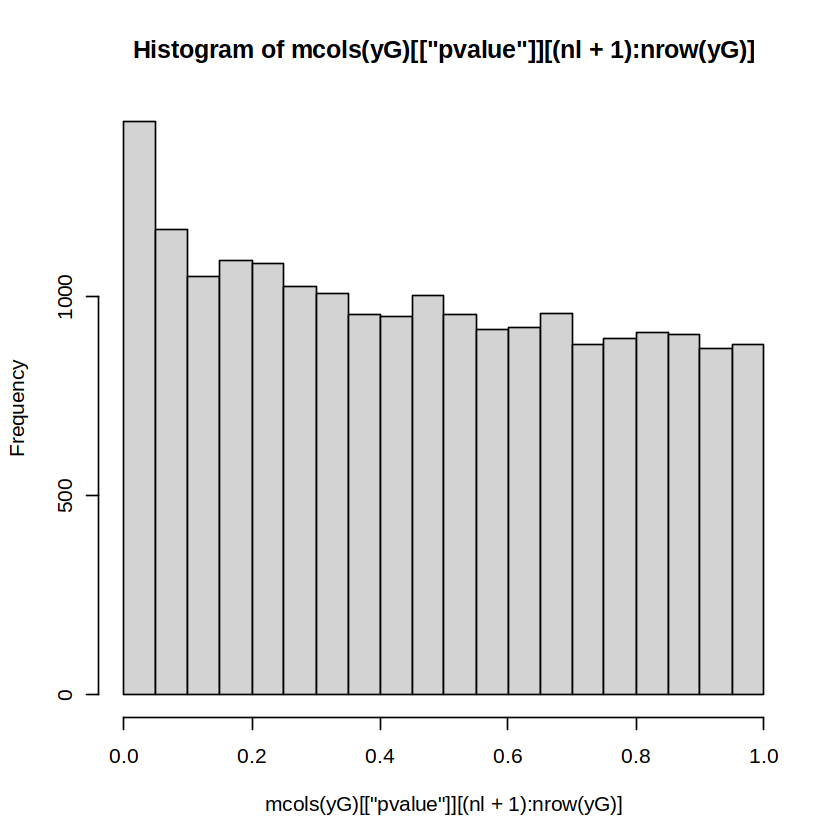

In [10]:
hist(mcols(yG)[["pvalue"]])
hist(mcols(yG)[["pvalue"]][1:nl])
hist(mcols(yG)[["pvalue"]][(nl+1):nrow(yG)])

In [30]:
infRepIdx <- grep("infRep", assayNames(txpGene))
# infRepError(infRepIdx)
infReps <- assays(txpGene)[infRepIdx]
nreps <- length(infReps)
length <- assays(txpGene)[["length"]]
l <- nrow(metadata(txpGene)[["txpsAnn"]])
meanDepth <- exp(mean(log(colSums(assays(txpGene)[["counts"]][1:l,]))))

In [ ]:
y <- tse[1:nl,]
y <- fishpond::scaleInfReps(y)
y <- labelKeep(y)
y <- swish(y, x="condition")
hist(mcols(y)[["pvalue"]])

#### Swish only at the leaf level with different transcripts randomly picked

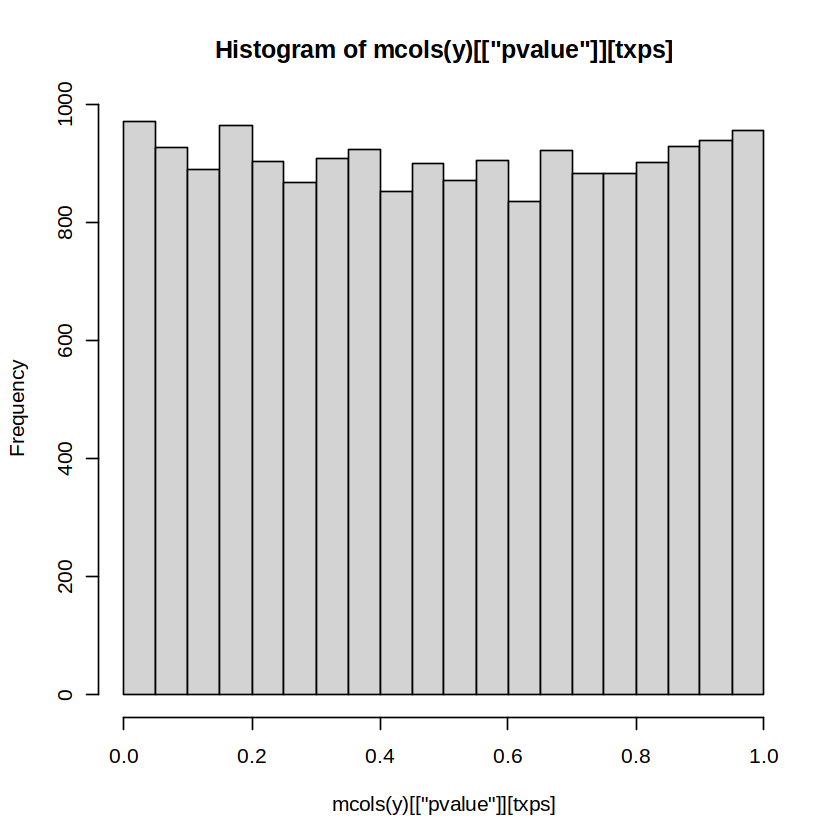

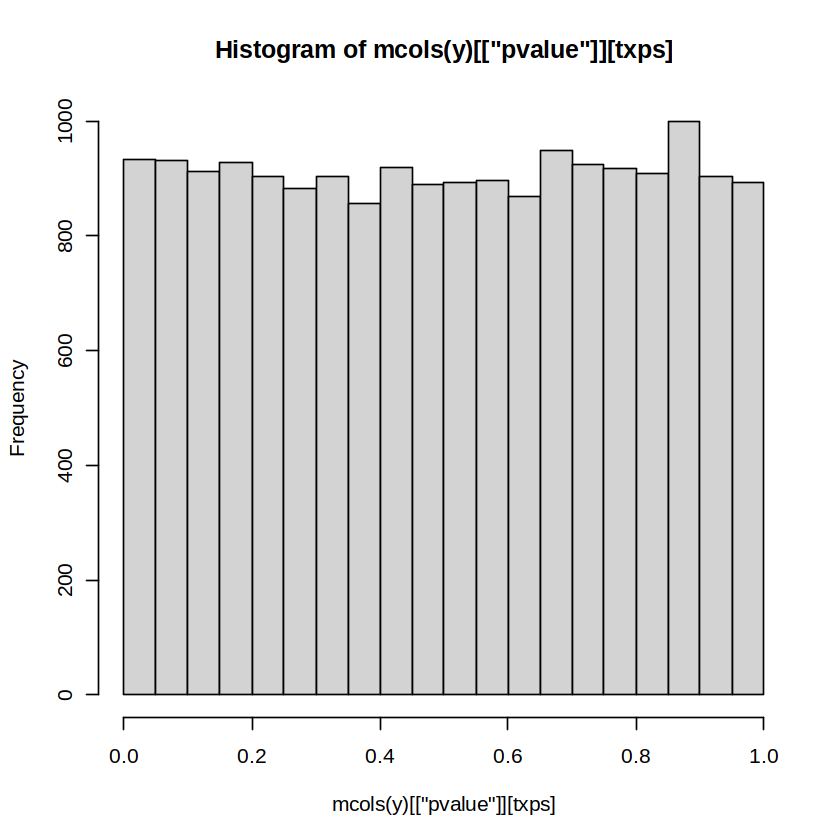

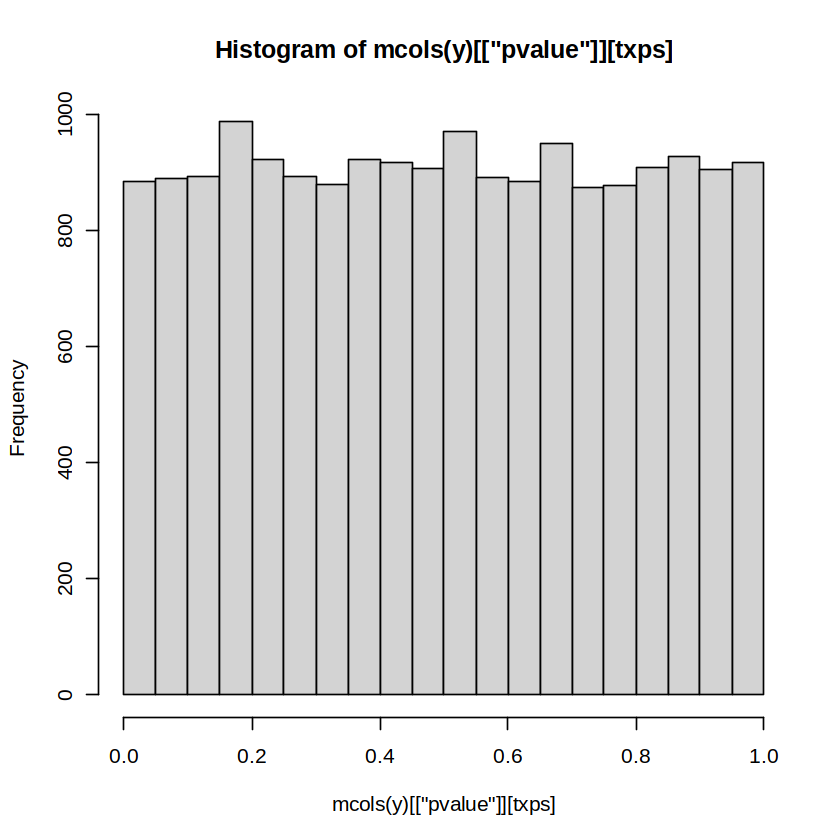

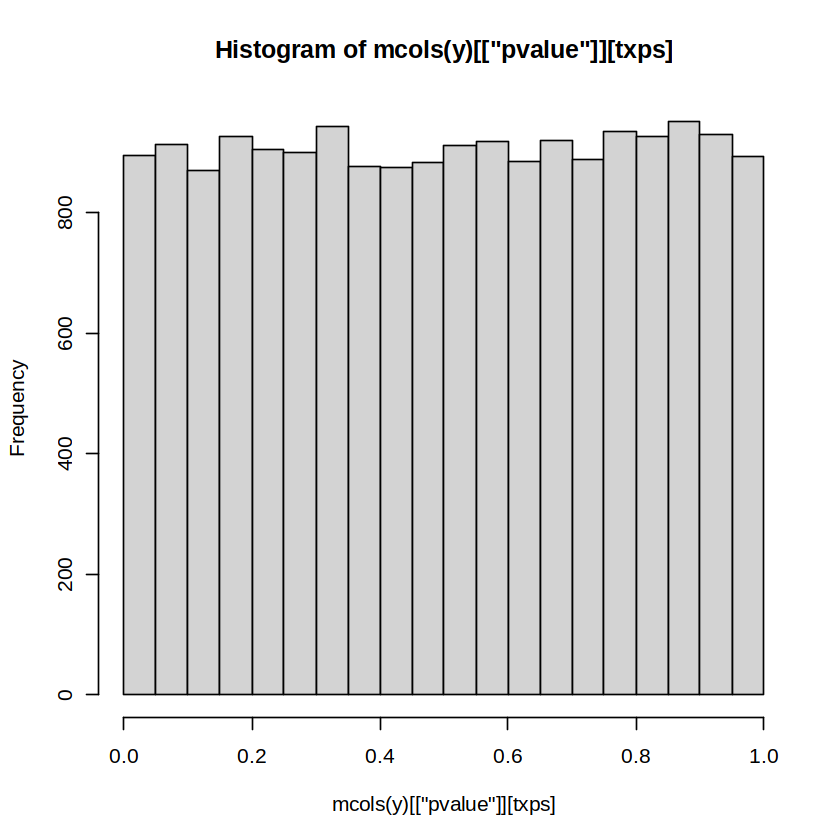

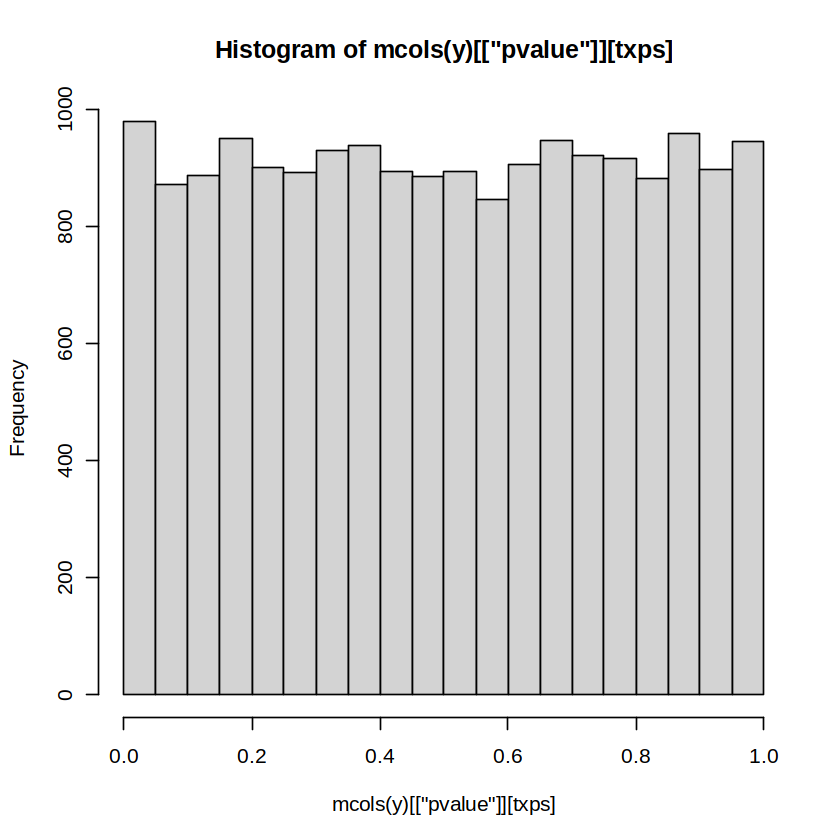

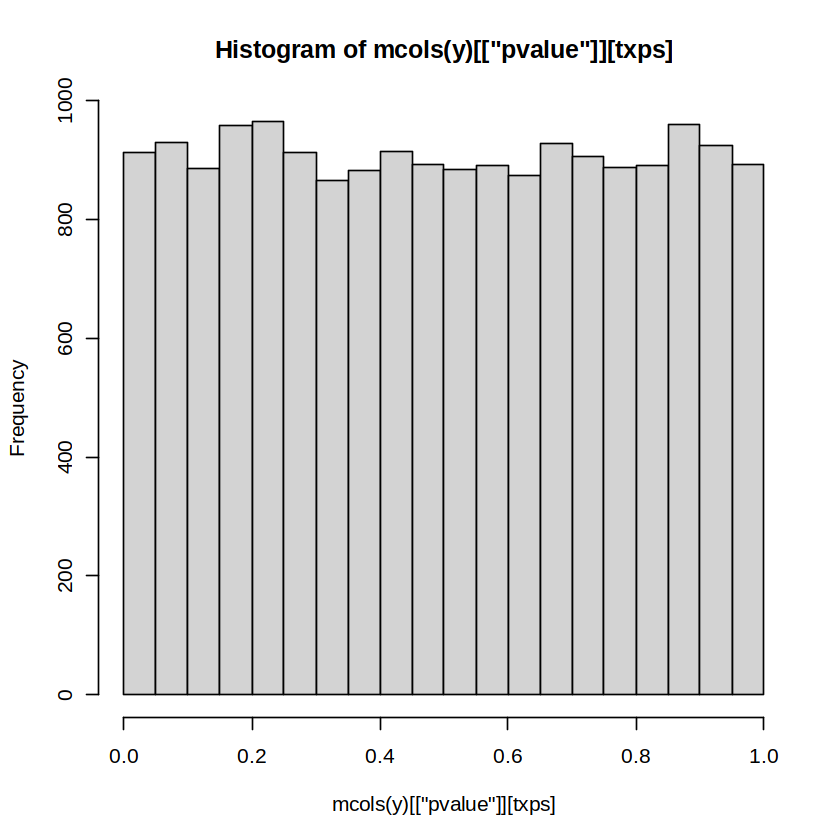

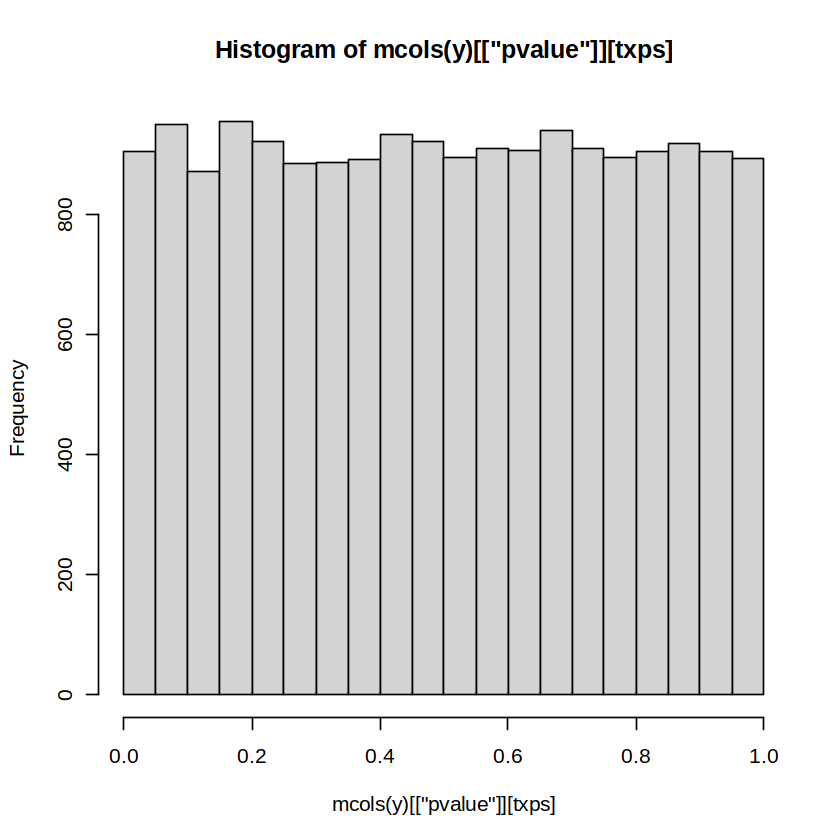

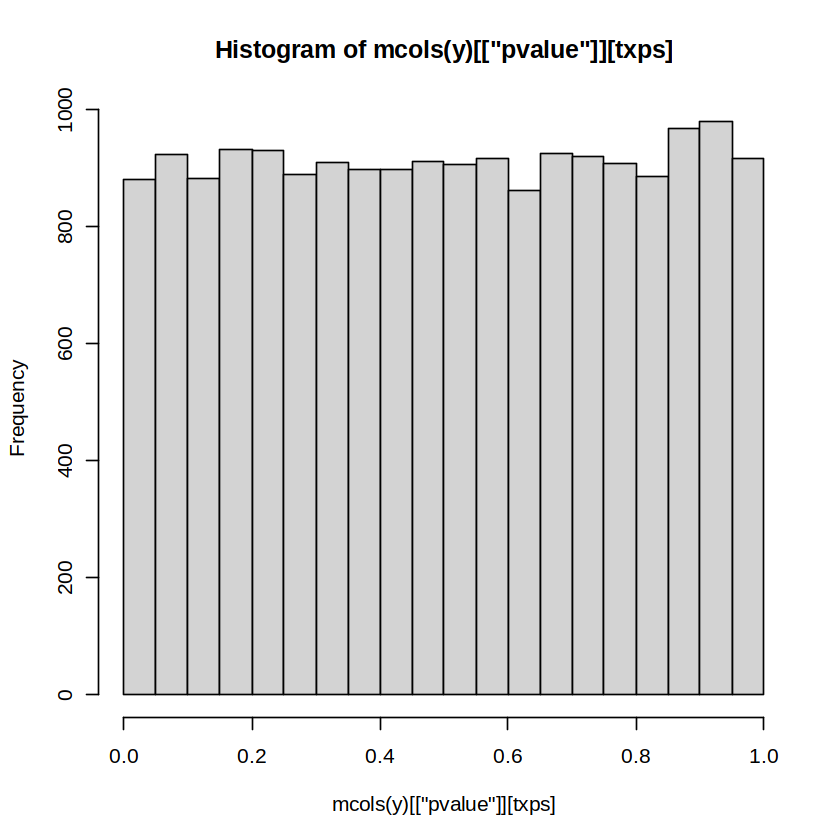

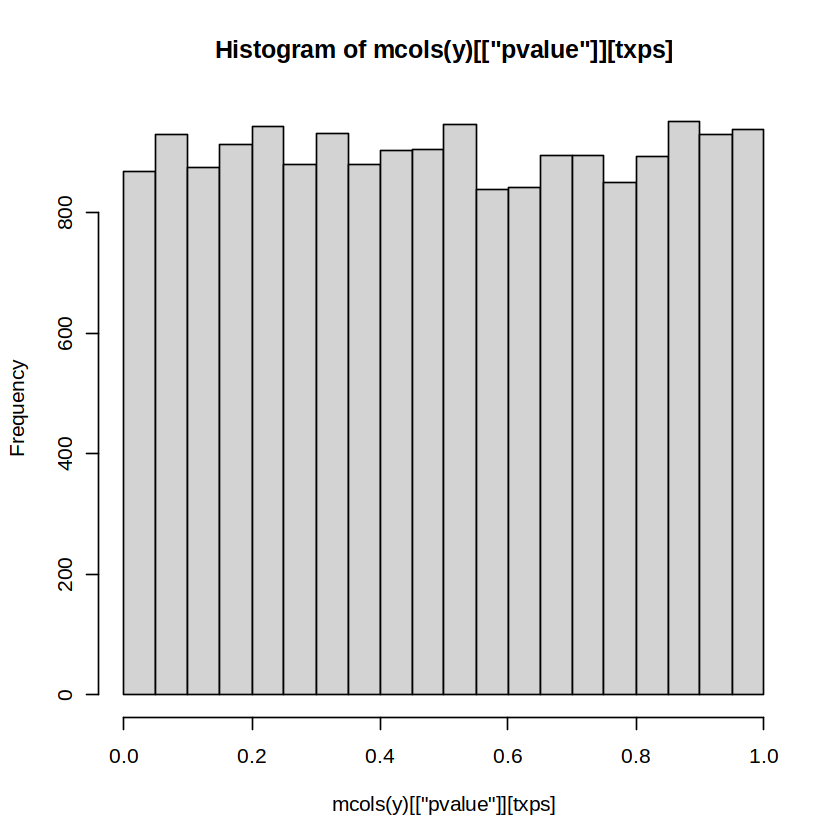

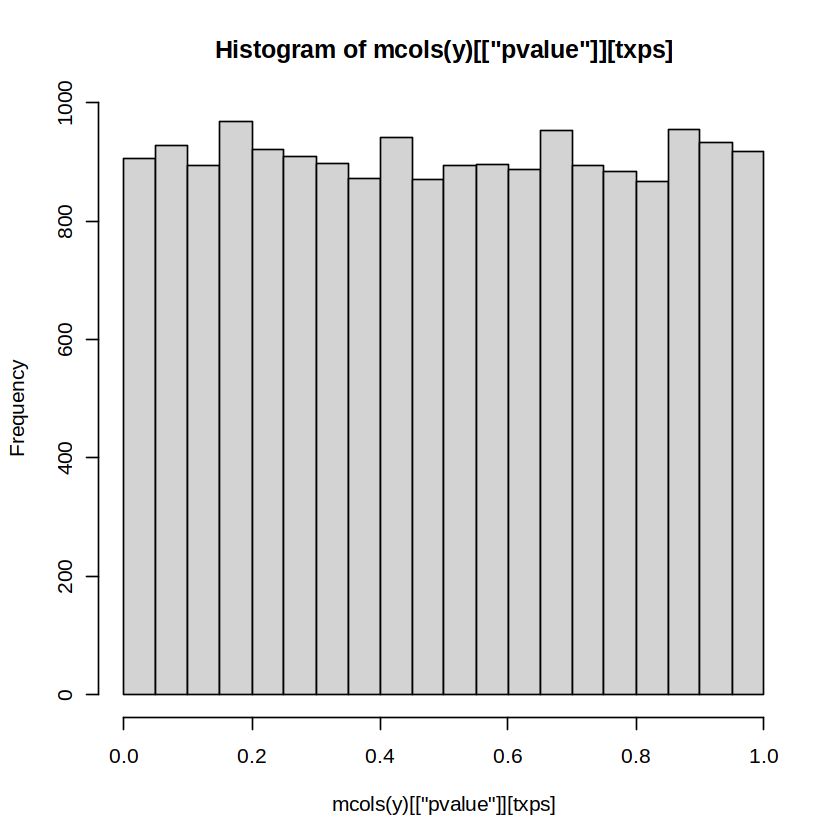

In [31]:
for(i in seq(10)) {
    txps <- sample(nrow(y), 40000)
    hist(mcols(y)[["pvalue"]][txps])
}

#### Swish on the entire tree

In [8]:
yAll <- computeSizeFactors(tse)
yAll <- scaleInfReps(yAll)
yAll <- labelKeep(yAll)

Setting inf rep depth to mean depth



Progress:   1 on 100Progress:   2 on 100Progress:   3 on 100Progress:   4 on 100Progress:   5 on 100Progress:   6 on 100Progress:   7 on 100Progress:   8 on 100Progress:   9 on 100Progress:  10 on 100Progress:  11 on 100Progress:  12 on 100Progress:  13 on 100Progress:  14 on 100Progress:  15 on 100Progress:  16 on 100Progress:  17 on 100Progress:  18 on 100Progress:  19 on 100Progress:  20 on 100Progress:  21 on 100Progress:  22 on 100Progress:  23 on 100Progress:  24 on 100Progress:  25 on 100Progress:  26 on 100Progress:  27 on 100Progress:  28 on 100Progress:  29 on 100Progress:  30 on 100Progress:  31 on 100Progress:  32 on 100Progress:  33 on 100Progress:  34 on 100Progress:  35 on 100Progress:  36 on 100Progress:  37 on 100Progress:  38 on 100Progress:  39 on 100Progress:  40 on 100Progress:  41 on 100Progress:  42 on 100Progress:  43 on 100Progress:  44 on 100Progress:  45 on 100Progress:  46 on 100Progress:  47 on 100Progress:  48 on 100Progress:  49 on 100Progress:  50 on 100

In [9]:
set.seed(1)
yInn <- swish(yAll[(nl+1):nrow(yAll),], x = "condition")
set.seed(10)
yTxps <- swish(yAll[1:nl,], x = "condition")

In [10]:
pvals <- c(mcols(yTxps)[["pvalue"]],mcols(yInn)[["pvalue"]])
mIRV <- mcols(yAll)[["meanInfRV"]]

In [23]:
tA <- climbMax(pvals, mIRV, tree, 0.4, 0.1, signs, cores=1)

In [ ]:
pvals[tA]

In [20]:
signs <- computeSign(yAll, "condition")
head(signs)

[1] -1 -1 -1  0 -1  0

#### Plotting the pvalue of nodes at the different heights computed by using all the nodes in the trees

In [43]:
names(metadata(yAll))

[1] "tximetaInfo"         "quantInfo"           "countsFromAbundance"
 [4] "level"               "txomeInfo"           "txdbInfo"           
 [7] "txpsAnn"             "infRepsScaled"       "type"               
[10] "sf"                  "preprocessed"

[1] 1
[1] 2


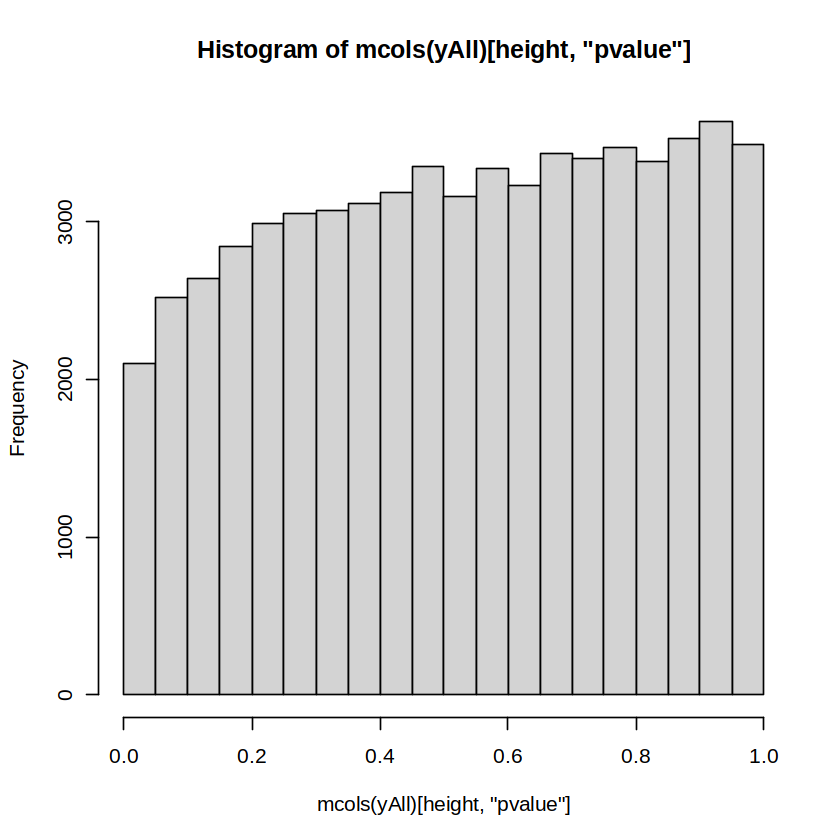

[1] 3


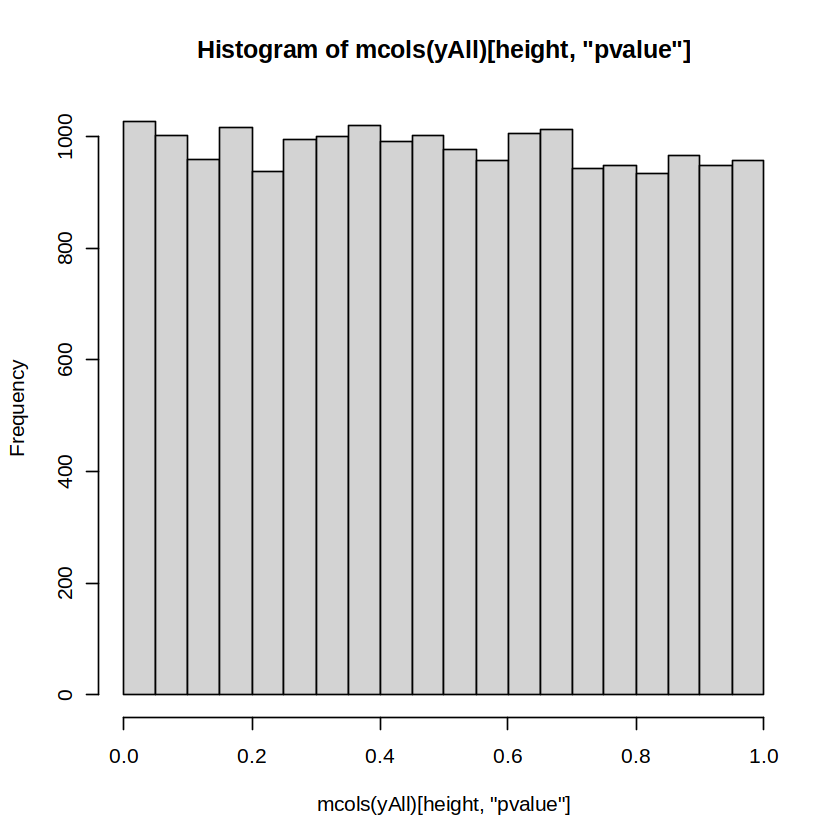

[1] 4


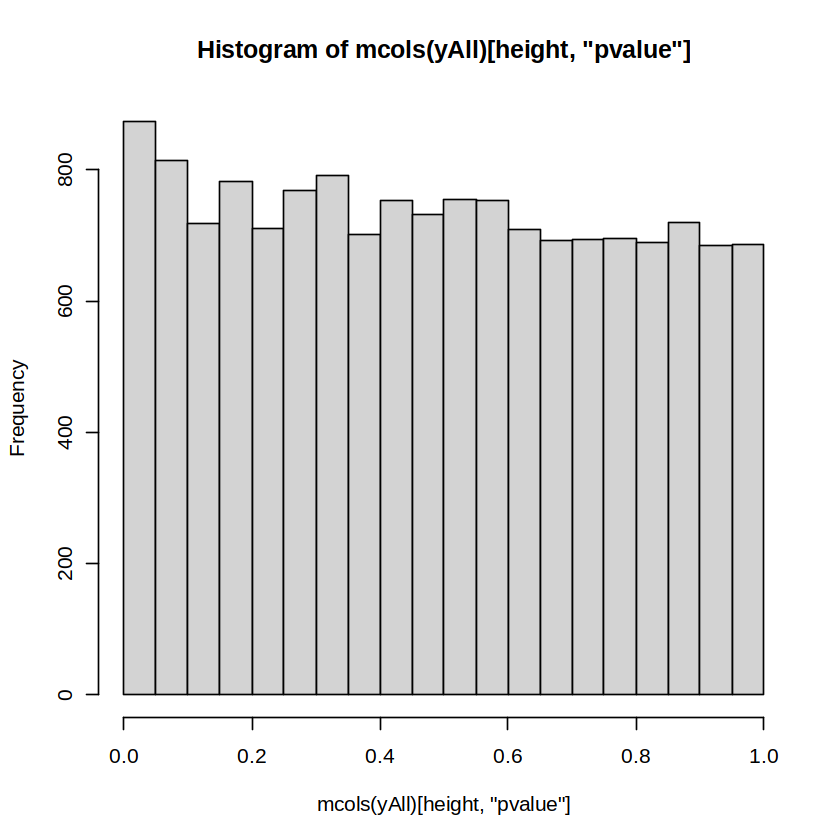

[1] 5


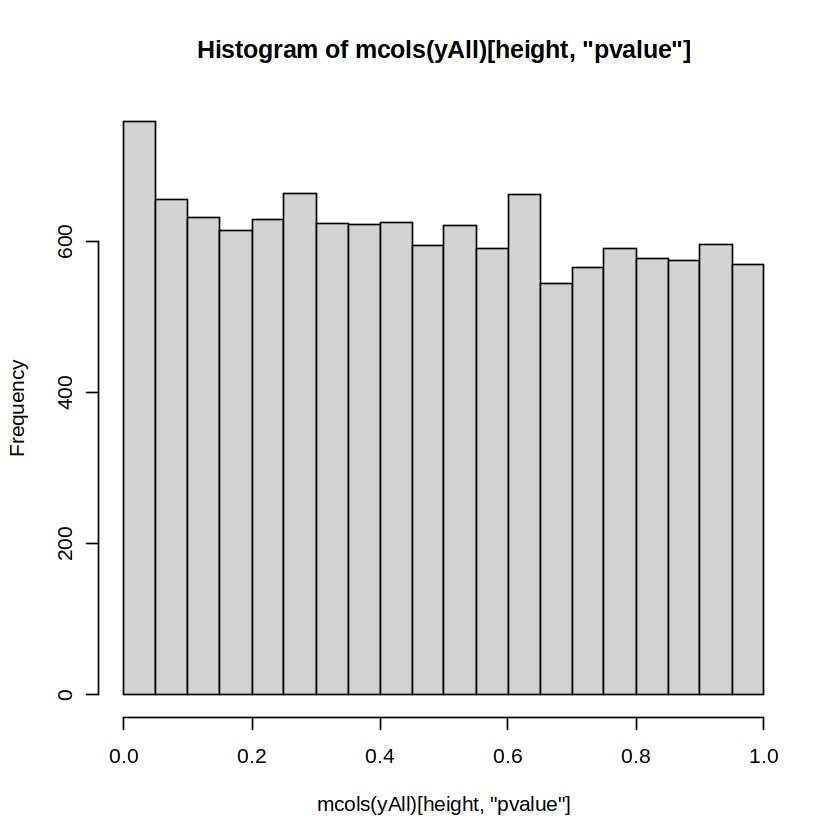

[1] 6


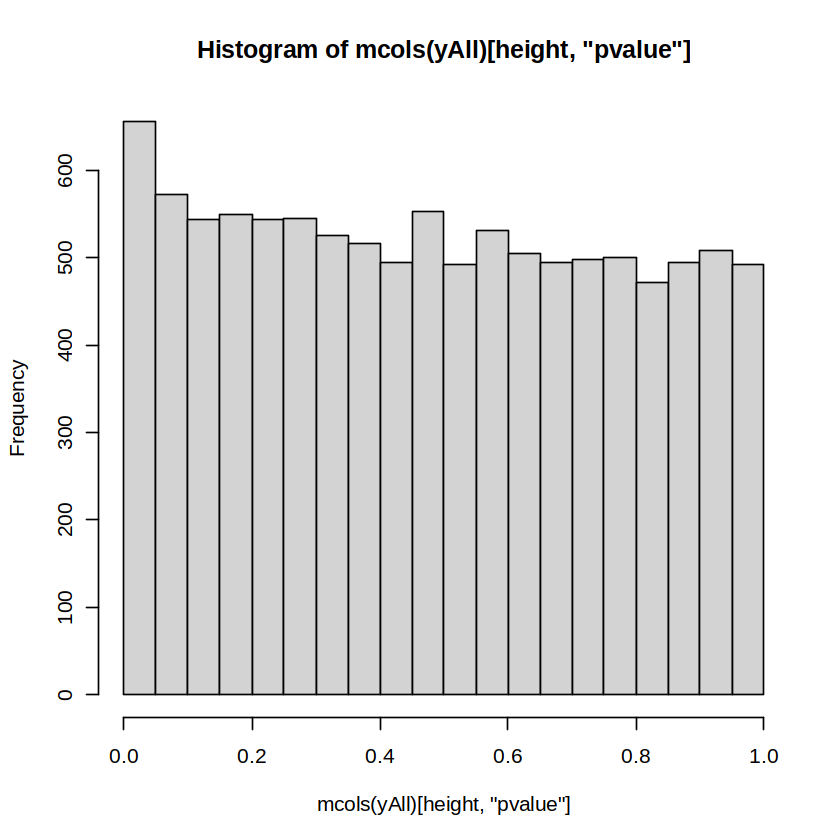

[1] 7


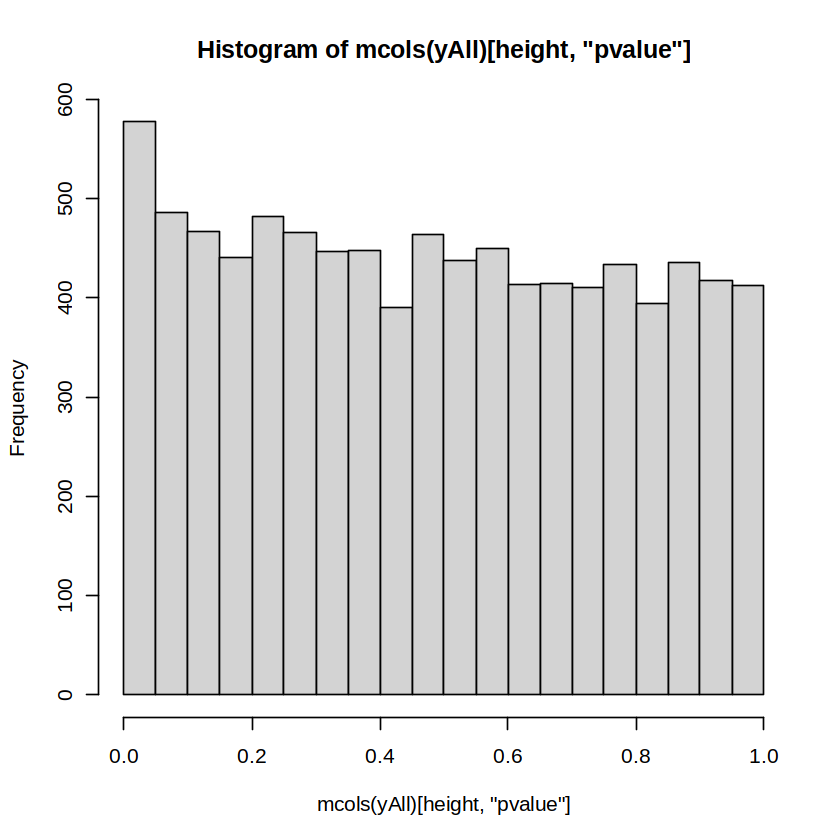

[1] 8


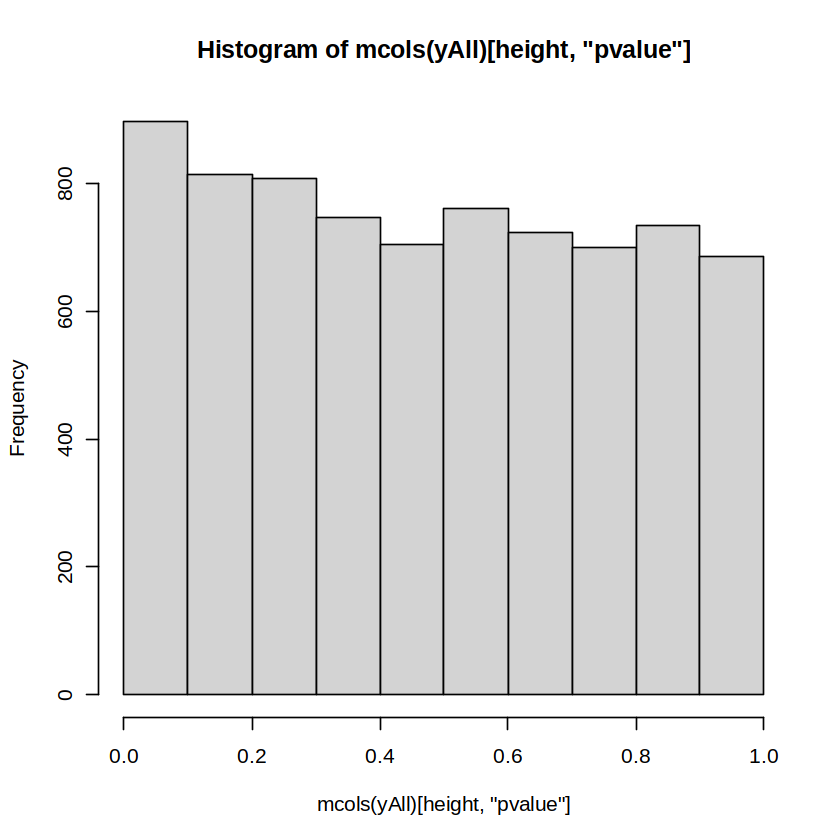

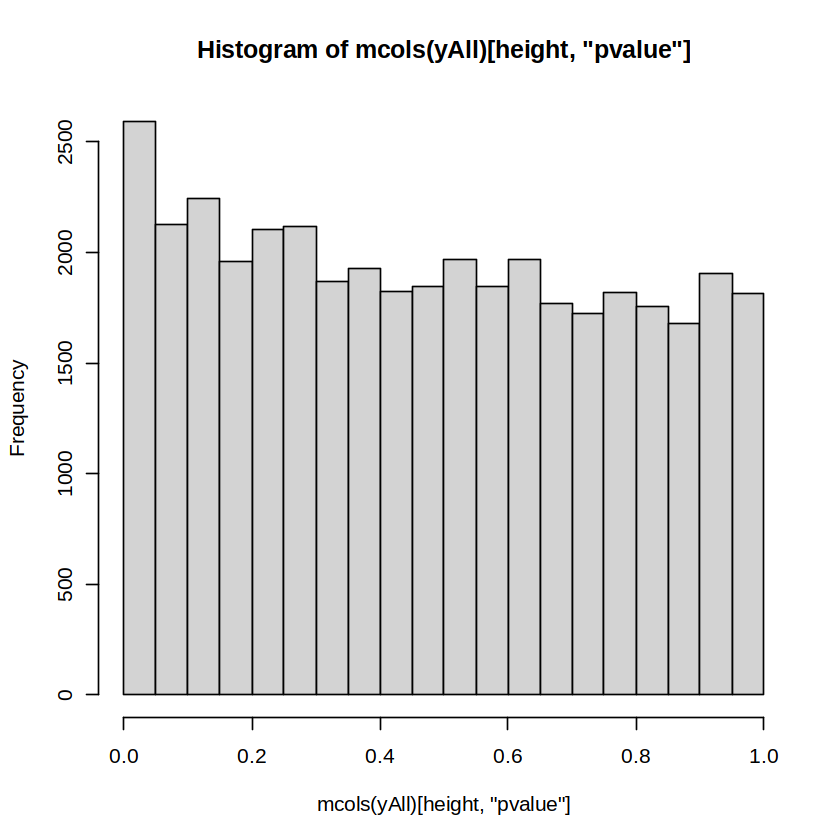

In [26]:
n <- 8
for(i in seq(n)) {
    print(i)
    if(i <= 7)
        height <- which(node.depth(tree, 2)==i)
    else
        height <- which(node.depth(tree, 2)>=i)
    hist(mcols(yAll)[height, "pvalue"])
}

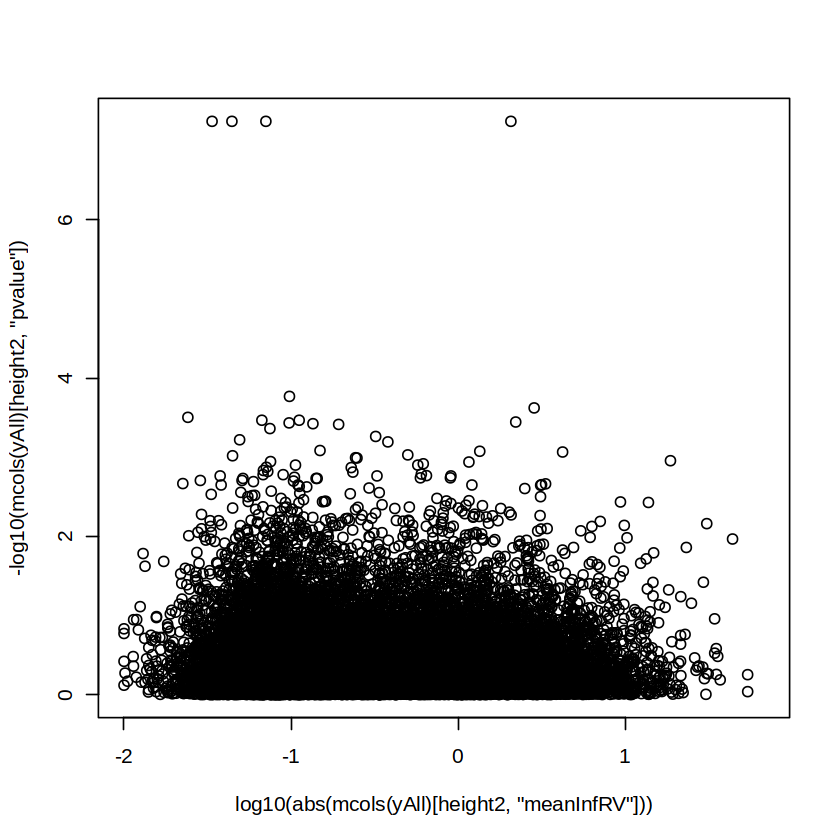

In [29]:
plot(log10(abs(mcols(yAll)[height2, "meanInfRV"])), -log10(mcols(yAll)[height2, "pvalue"]))

#### Running swish separately on the inner nodes and the leaves

In [20]:
set.seed(1)
y1 <- swish(yAll[1:nl,], x="condition")

set.seed(1)
y2 <- swish(yAll[(nl+1):nrow(yAll),], x="condition")

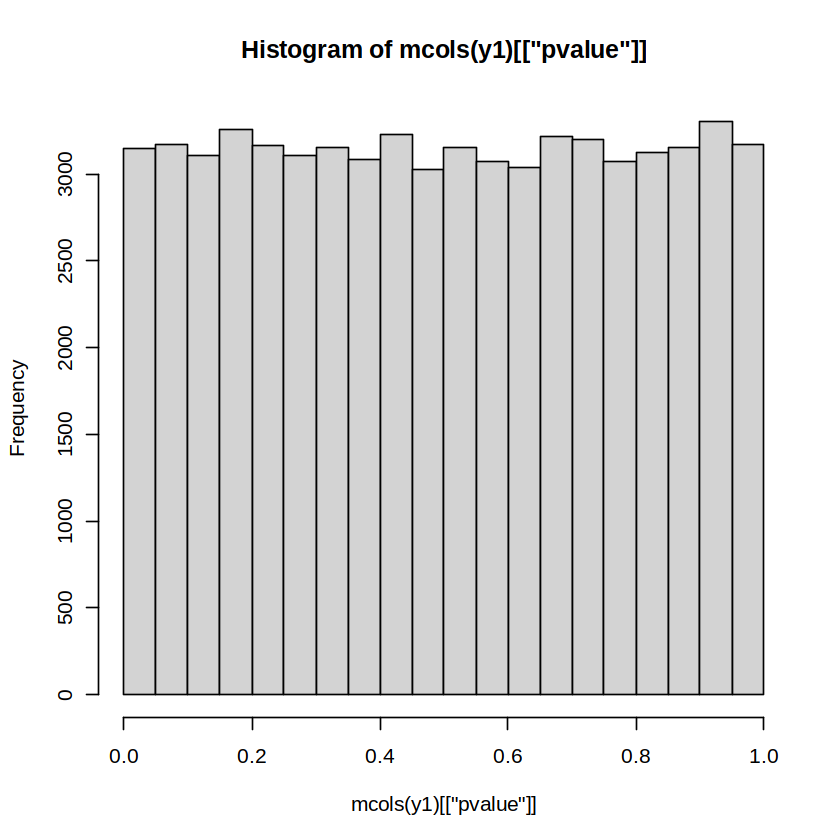

In [21]:
hist(mcols(y1)[["pvalue"]])

#### Distribution of pvalues on the inner nodes at the different heights when run only on the inner nodes

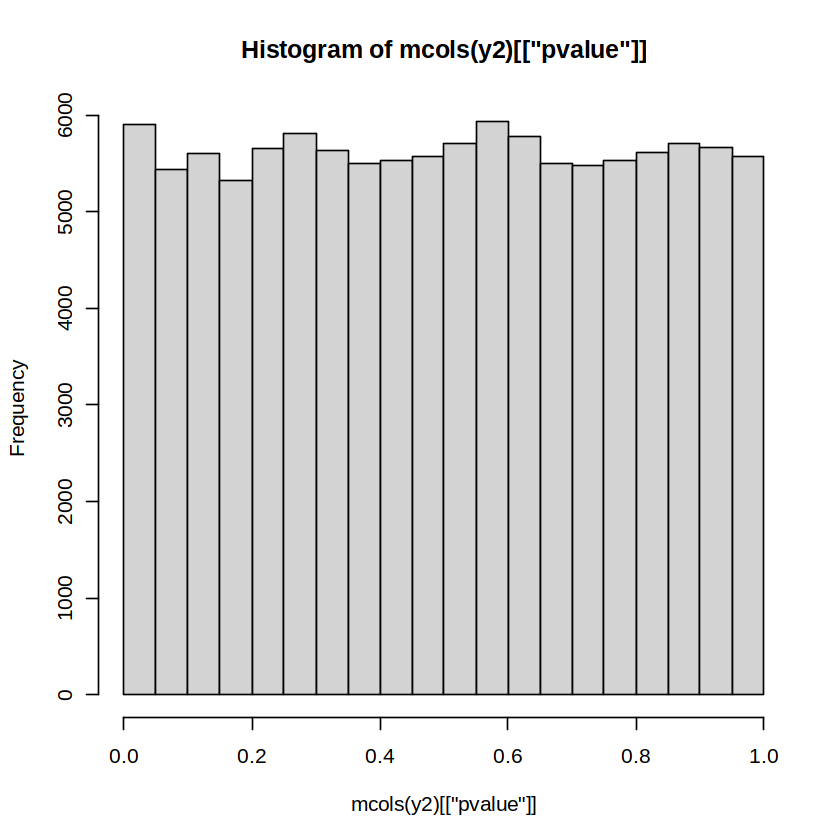

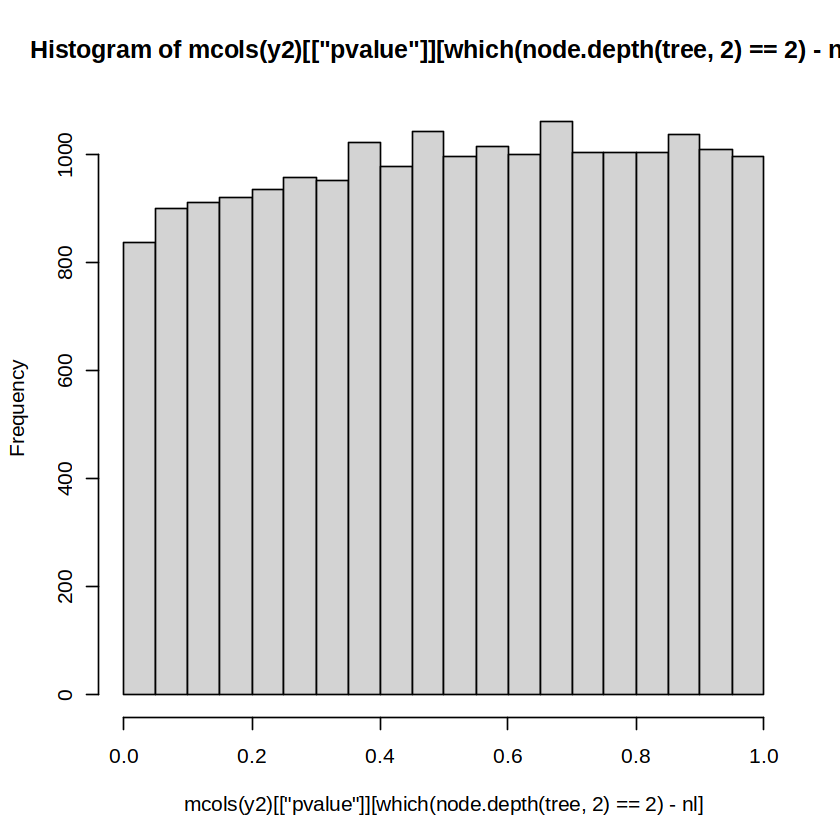

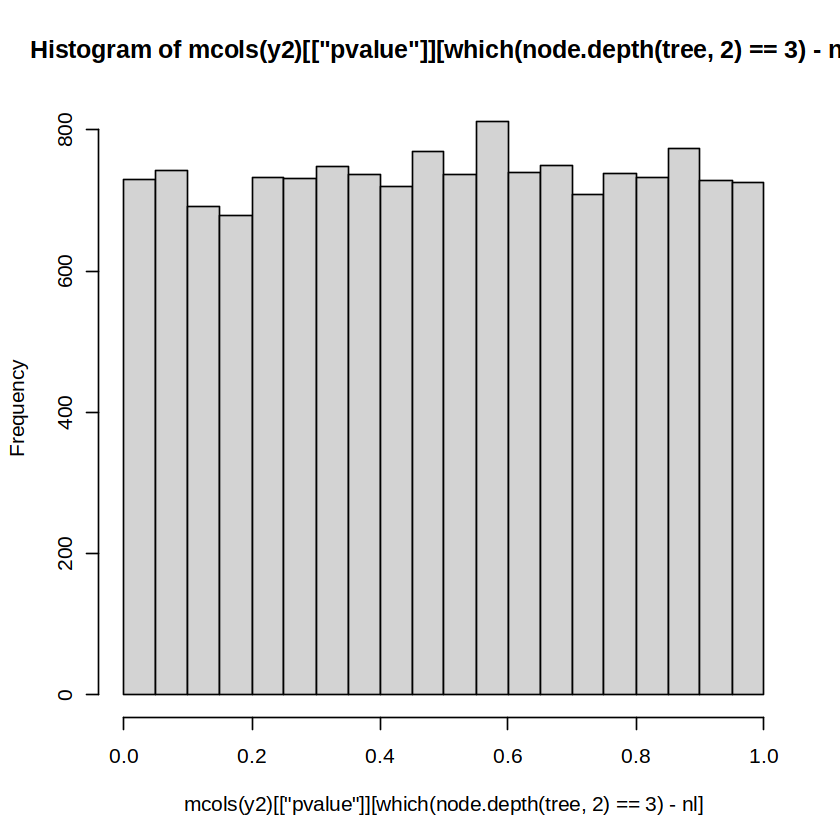

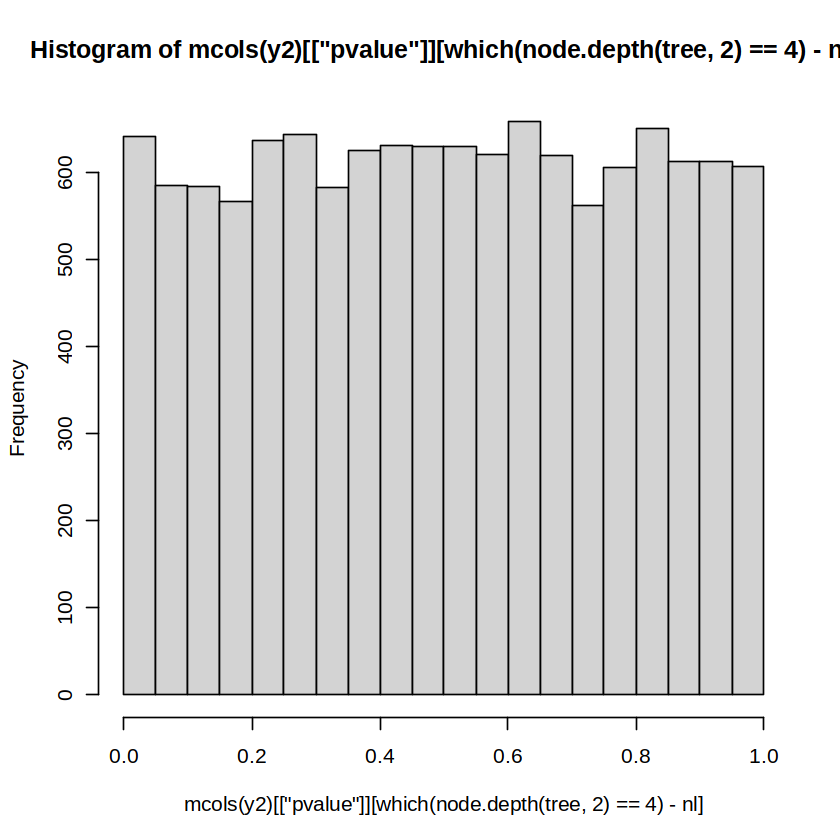

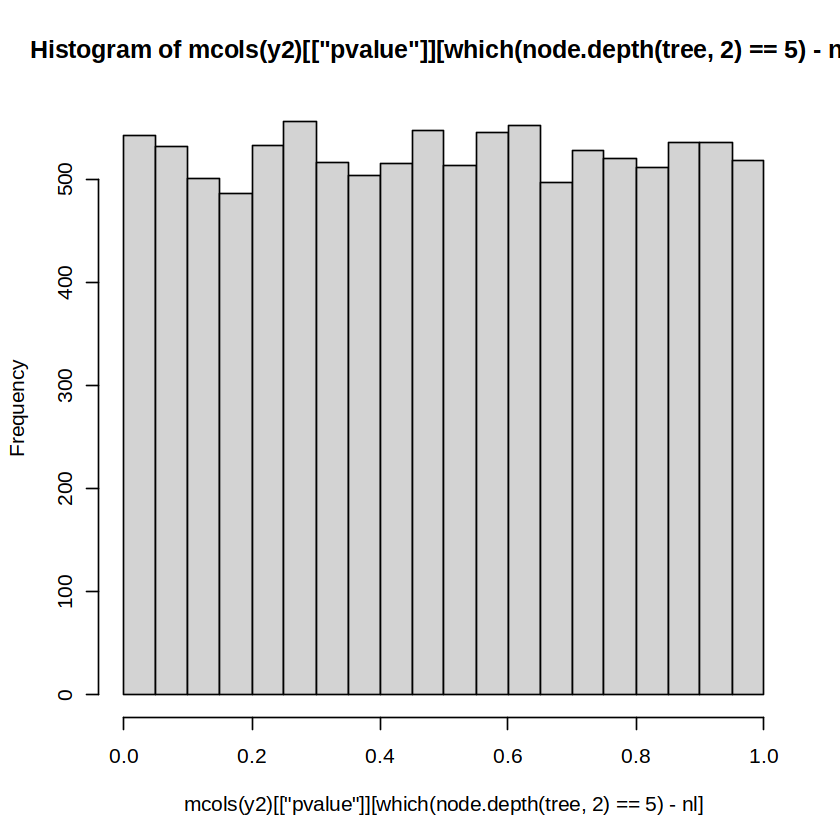

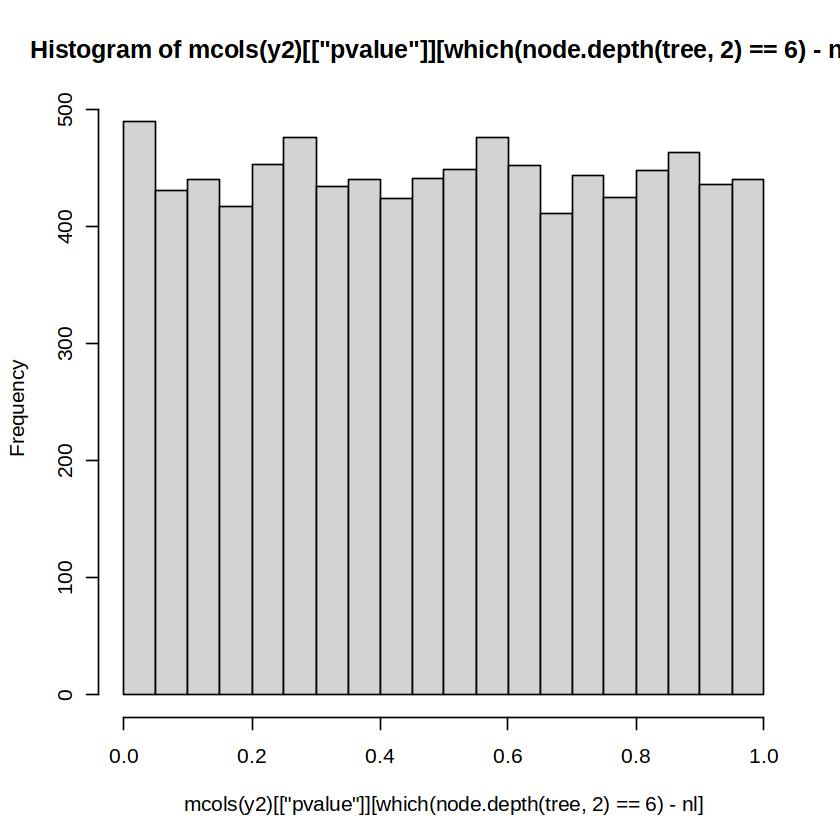

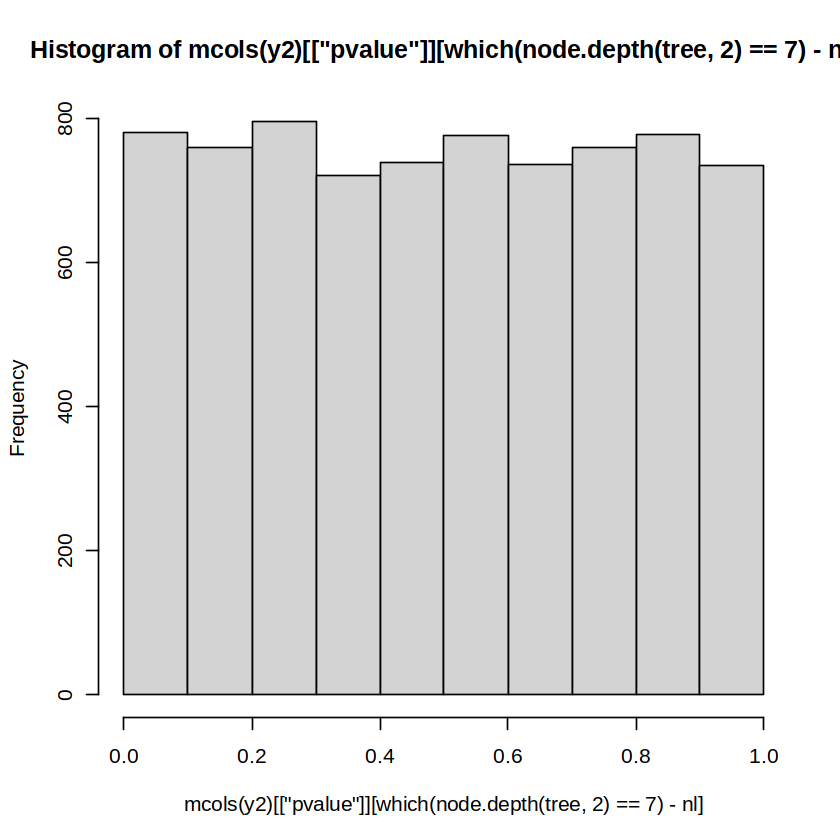

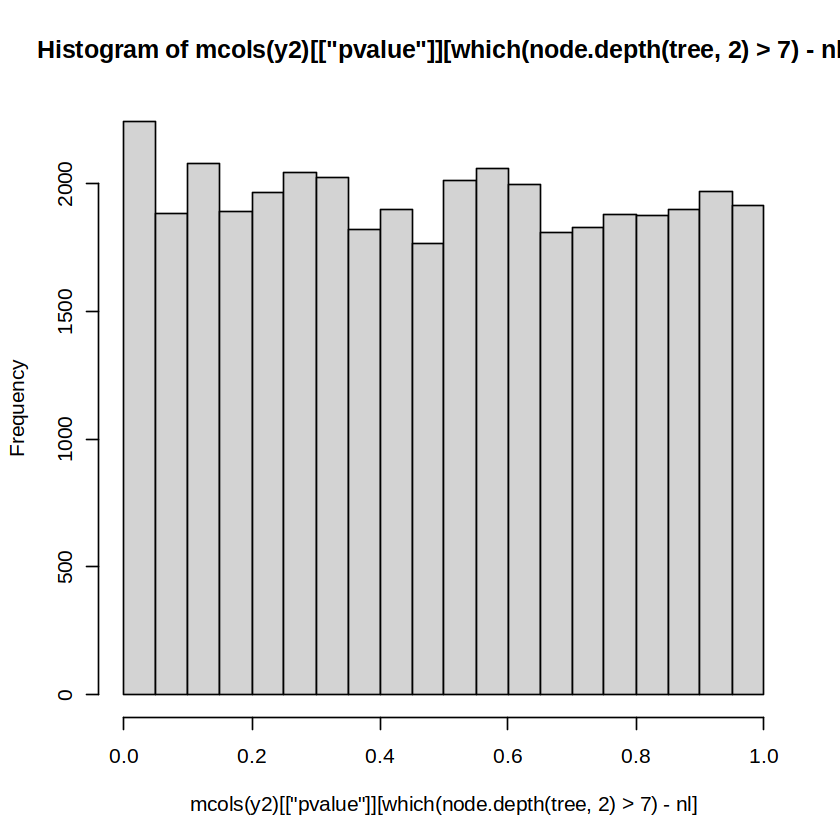

In [41]:
hist(mcols(y2)[["pvalue"]])
hist(mcols(y2)[["pvalue"]][which(node.depth(tree,2)==2)-nl])
hist(mcols(y2)[["pvalue"]][which(node.depth(tree,2)==3)-nl])
hist(mcols(y2)[["pvalue"]][which(node.depth(tree,2)==4)-nl])
hist(mcols(y2)[["pvalue"]][which(node.depth(tree,2)==5)-nl])
hist(mcols(y2)[["pvalue"]][which(node.depth(tree,2)==6)-nl])
hist(mcols(y2)[["pvalue"]][which(node.depth(tree,2)==7)-nl])
hist(mcols(y2)[["pvalue"]][which(node.depth(tree,2)>7)-nl])

In [84]:
iNodes <- (nl+1):nrow(yAll)
cNodes <- Descendants(tree, iNodes, "child")

In [90]:
sNodes <- iNodes[sapply(cNodes, function(nodes) all(mcols(yAll)[["meanInfRV"]][nodes] > 0.4))]

[1] 138318 138327 138328 138329 138334 138335

[1] 25070

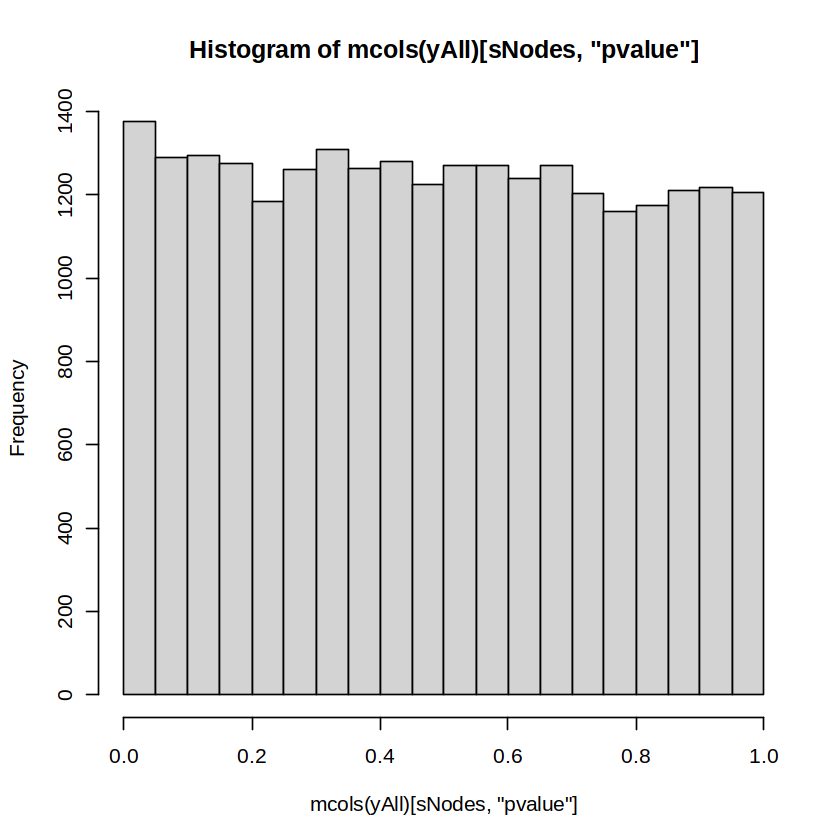

In [91]:
head(sNodes)
length(sNodes)
hist(mcols(yAll)[sNodes, "pvalue"])

In [94]:
mcols(yAll)[unlist(Descendants(tree, sNodes[1:10], "child")), "meanInfRV"]

ENST00000349258.8  ENST00000258613.4         Node138328  ENST00000372075.1 
         3.3569412          3.1163089          0.5537757          3.7506481 
        Node138329 ENST00000263070.11  ENST00000298767.9  ENST00000618527.4 
         3.2523417         23.9161416         30.1515375         37.6992048 
        Node138335  ENST00000432543.6  ENST00000377026.4  ENST00000398425.7 
         2.0996604         10.9120165          2.2537029         30.7778539 
        Node138340         Node138341  ENST00000503156.5  ENST00000322224.8 
         0.6522633          0.5714244          0.9640808          1.3977353 
        Node138342  ENST00000404286.6  ENST00000512400.1  ENST00000515118.5 
         0.7240198          1.3445975          1.1504846          1.6096168